In [1]:
!pip install numpy==1.21
!pip install matplotlib==3.1.3
!pip install dtreeviz
!pip install kneed
!pip install pyclustertend
!pip install geopandas
!pip install pyreadstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.7 MB 389 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 854 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.7 MB 4.4 MB/s 
     |████████████████████████████████| 3.3 MB 42.0 MB/s 
     |████████████████████████████████| 15.4 MB 51.4 MB/s 
     |████████████████████████████████| 9.4 MB 40.1 MB/s 
     |████████████████████████████████| 965 kB 33.4 MB/s 
     |████████████████████████████████| 295 kB 85.7 MB/s 
     |████████████████████████████████| 26.3 MB 1.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.0
    Uninstalling numpy-1.21.0:
      Successfully uninstalled numpy-1.21.0
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Unin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.9 MB/s 
     |████████████████████████████████| 16.6 MB 51.0 MB/s 
     |████████████████████████████████| 7.8 MB 51.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.7 MB 5.3 MB/s 


In [2]:
#Data sets
import pandas as pd
import numpy as np
import csv
import geopandas as gp
from collections import defaultdict

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz.trees as dtreeviz
import plotly.graph_objects as go
%matplotlib inline

#modelos y métricas
import statistics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegressionCV, Lasso
from sklearn import tree, metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score, precision_score, auc, roc_auc_score, mean_squared_error, silhouette_score, classification_report,mean_absolute_error, max_error, median_absolute_error, r2_score, explained_variance_score
import xgboost as xgb
from sklearn.svm import SVR
#preprocesamiento
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Data sets

In [3]:
url = 'https://drive.google.com/file/d/1ziV8Kmuw_Vtv7aX1zGnfMdoLMd0nfoOr/view?usp=share_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

ds_train = pd.read_csv(path)

url = 'https://drive.google.com/file/d/1j34_hlvFOJV_8TN2jdnV2GXSArfWlUUK/view?usp=share_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

ds_test = pd.read_csv(path)

Ponemos valores numéricos para trabajar con los tipos de propiedades

In [4]:
de_temp_train = ds_train.copy()

de_temp_train.loc[ds_train["tipo_precio"]=="bajo", "target"]= 0
de_temp_train.loc[ds_train["tipo_precio"]=="medio", "target"]= 1
de_temp_train.loc[ds_train["tipo_precio"]=="alto", "target"]= 2

In [5]:
de_temp_test = ds_test.copy()

de_temp_test.loc[ds_test["tipo_precio"]=="bajo", "target"]= 0
de_temp_test.loc[ds_test["tipo_precio"]=="medio", "target"]= 1
de_temp_test.loc[ds_test["tipo_precio"]=="alto", "target"]= 2

In [6]:
ds_train_x = de_temp_train.drop(['id', 'tipo_precio', 'property_price', 'target'], axis='columns', inplace=False)
ds_test_x = de_temp_test.drop(['id', 'tipo_precio', 'property_price', 'target'], axis='columns', inplace=False)

In [7]:
ds_train_x = pd.get_dummies(ds_train_x, columns=["barrio","property_type"], drop_first=True)
ds_test_x = pd.get_dummies(ds_test_x, columns=["barrio","property_type"], drop_first=True)

### Funciones generales

In [8]:
#Funcion para plotear la performance
def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

In [9]:
#Funcion para evaluar los modelos 5fold -CV
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

### Voting

In [10]:
ds_train_y = de_temp_train['target'].copy()
ds_test_y = de_temp_test['target'].copy()

In [11]:
sscaler=StandardScaler()
sscaler.fit(pd.DataFrame(ds_train_x))

StandardScaler()

In [12]:
x_train_transform=sscaler.transform(pd.DataFrame(ds_train_x))
x_test_transform=sscaler.transform(pd.DataFrame(ds_test_x))

Usamos DecisionTree, RandomForest y AdaBoost

In [13]:
#Creamos los clasificadores
tree_classifier = tree.DecisionTreeClassifier()
rf = RandomForestClassifier()
adaboost = AdaBoostClassifier()

#Entreno clasificadores
voting = VotingClassifier(estimators=[('tree', tree_classifier), ('rf', rf), ('adaboost', adaboost)], voting='hard')

#Entreno el ensemble
voting.fit(x_train_transform, ds_train_y)

VotingClassifier(estimators=[('tree', DecisionTreeClassifier()),
                             ('rf', RandomForestClassifier()),
                             ('adaboost', AdaBoostClassifier())])

In [14]:
y_pred = voting.predict(x_test_transform)

              precision    recall  f1-score   support

         0.0       0.67      0.81      0.73      5336
         1.0       0.60      0.48      0.54      5327
         2.0       0.75      0.73      0.74      5332

    accuracy                           0.68     15995
   macro avg       0.67      0.68      0.67     15995
weighted avg       0.67      0.68      0.67     15995

Accuracy: 0.6756486402000625
 


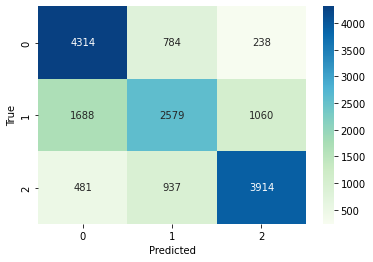

In [15]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(ds_test_y,y_pred)

print(classification_report(ds_test_y,y_pred))
print("Accuracy: "+str(accuracy))
print(" ")

#Creo la matriz de confusión
tabla=confusion_matrix(ds_test_y, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
# Guardamos el modelo
import pickle

filename = 'voting.sav'
pickle.dump(voting, open(filename, 'wb'))

####Conclusiones voting

El accuracy es aceptable, consideramos que no se sobreajusta al modelo, pero nos gustaría que se ajustara un poco más a los datos de entrenamiento.

### Staking

In [17]:
ds_train_y = de_temp_train['property_price'].copy()
ds_test_y = de_temp_test['property_price'].copy()

In [18]:
base_models = estimators = [('xgboost',xgb.XGBRegressor()),('knnr', KNeighborsRegressor()),('gradient_boosting_regressor', GradientBoostingRegressor())]

#Modelo para definir que modelo usar
meta_model = RandomForestRegressor(n_estimators=5,random_state=42)

#Guarda los scores de cada modelo
model_scores = defaultdict()

for base_model in base_models:
    model_name = base_model[0]
    model = base_model[1]

    print('Evaluating {}'.format(model_name))
    scores = evaluate_model(model, ds_train_x, ds_train_y)
    model_scores[model_name] = scores

reg = StackingRegressor(
     estimators=base_models,
     final_estimator = meta_model, passthrough=True, cv=5, verbose=2)

     
stacking_scores = evaluate_model(reg, ds_train_x, ds_train_y)

#Agregamos stacking para poder graficar luego
model_scores['stacking'] = stacking_scores 

Evaluating xgboost


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.6min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating knnr


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.4min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating gradient_boosting_regressor


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  2.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 22.4min finished


In [19]:
reg.fit(ds_train_x, ds_train_y)
y_pred = reg.predict(ds_test_x)

[23:26:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[23:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.8s remaining:    0.0s


[23:26:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:27:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:27:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   48.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished


In [20]:
mse = metrics.mean_squared_error(y_true = ds_test_y, y_pred  = y_pred, squared = True)
rmse = metrics.mean_squared_error(y_true = ds_test_y, y_pred = y_pred, squared = False)

print(f"El error (mse) de test es: {mse}")
print(f"El error (rmse) de test es: {rmse}")

El error (mse) de test es: 11906547693.986822
El error (rmse) de test es: 109117.12832542296


In [21]:
#Grafico performance
plot_results(model_scores, name='stacking_model_cv')

In [23]:
# Guardamos el modelo
filename = 'stacking.sav'
pickle.dump(reg, open(filename, 'wb'))

####Conclusiones stacking

Obtuvimos buenos resultados de los modelos particulares, exceptuando KNeighbors. Aprendiendo de lo visto entre todos los modelos pudimos generar resultados finales mejores a los obtenidos por cualquier modelo de manera independiente.

###Conclusiones generales de ensambles de modelos

El stacking muestra claramente que para los datos que tenemos se puede ajustar mucho mejor con un ensamble de modelos, que Voting. De igual manera, hay que tener en cuenta que para hacer stacking usamos métodos que nos dieron muy buenos resultados en el TP1, principalmente los de gradient boosting.

En general, en comparacion con los demas modelos de regresion, Stacking tiene un RMSE mucho menor a XGBoost y a Redes Neuronales ya sean multicapa o de una sola capa. 

Y en comparacion a los demas modelos de clasificacion, Voting tiene un accuracy superior pero no por un margen muy grande.

En conclusion nos sorprendio los resultados de Stacking para realizar regresiones, pero al mismo tiempo es bastante logico teniendo en cuenta el enfoque que tiene para el entrenamiento. 